In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier

from imblearn.over_sampling import SMOTE

SEED = 12

The data frame will be created from the train data only and from there the split between training and testing data will be generated.
The test csv files won't be used at all for this exercise.

In [2]:
# Create data frames
client_train = pd.read_csv(f'data/client_train.csv', low_memory=False)
invoice_train = pd.read_csv(f'data/invoice_train.csv', low_memory=False)

# Data exploration

#### client_train data frame

The dataset does not contain nulls or repeated values. However, a few data types and headers need adjusment

In [3]:
# Data frame shape
print(f'the dataset contains {client_train.shape[0]} rows and {client_train.shape[1]} columns')

the dataset contains 135493 rows and 6 columns


In [4]:
# Print top rows of dataset
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [5]:
# Check nulls
client_train.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

In [6]:
# Check duplicates
print(f'The dataset contains {client_train.duplicated().sum()} duplicates')

The dataset contains 0 duplicates


In [7]:
# Get a summary for all numerical columns
round(client_train.describe(),2)

,disrict,client_catg,region,target
count,135493.00,135493.00,135493.00,135493.00
mean,63.51,11.51,206.16,0.06
std,3.35,4.42,104.21,0.23
min,60.00,11.00,101.00,0.00
25%,62.00,11.00,103.00,0.00
50%,62.00,11.00,107.00,0.00
75%,69.00,11.00,307.00,0.00
max,69.00,51.00,399.00,1.00


In [8]:
# Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [9]:
# Get unique values 
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


## Data Types and Transforming Data

In [10]:
# type of first date entry
type(client_train['creation_date'][0])

str

In [11]:
# change "creation_date" dtype to datetime with format %d/%m/%Y
client_train['creation_date'] = pd.to_datetime(client_train['creation_date'], format='%d/%m/%Y')

In [12]:
# check "creation_date" dtype
type(client_train['creation_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [13]:
# Change the data type for disrict, client_catg, reion, and target
client_train = client_train.astype({
    'disrict' : 'category',
    'client_catg' : 'category',
    'region' : 'category', 
    'target': int })

In [14]:
# Check new data types
client_train.dtypes

disrict                category
client_id                object
client_catg            category
region                 category
creation_date    datetime64[ns]
target                    int32
dtype: object

#### invoice_train dataset

The data does not contain nulls. However, there are duplicates and data types issues. It is especially concerning the mix data types in colum counter_number.

In [15]:
# Data frame shape
print(f'the dataset contains {invoice_train.shape[0]} rows and {invoice_train.shape[1]} colums')

the dataset contains 4476749 rows and 16 colums


In [16]:
# print top rows of dataset
invoice_train.head(5)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [17]:
# Check nulls
invoice_train.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [18]:
print(f'The dataset contains {invoice_train.duplicated().sum()} duplicates')

The dataset contains 11 duplicates


In [19]:
# Get a summary for all numerical columns
round(invoice_train.describe(),2)

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4476749.00,4.476749e+06,4476749.00,4476749.00,4476749.00,4476749.00,4476749.00,4476749.00,4476749.00,4476749.00,4476749.00,4476749.00
mean,20.13,1.230587e+11,172.49,7.32,1.00,410.98,109.32,20.31,52.93,17767.00,18349.70,44.83
std,13.47,1.657267e+12,133.89,1.57,0.31,757.31,1220.12,157.42,875.47,40366.93,40953.21,3128.34
min,8.00,0.000000e+00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,11.00,1.211080e+05,5.00,6.00,1.00,79.00,0.00,0.00,0.00,1791.00,2056.00,4.00
50%,11.00,4.945610e+05,203.00,8.00,1.00,274.00,0.00,0.00,0.00,7690.00,8192.00,4.00
75%,40.00,1.115161e+06,207.00,9.00,1.00,600.00,0.00,0.00,0.00,21660.00,22343.00,4.00
max,45.00,2.798115e+13,600.00,413.00,50.00,999910.00,999073.00,64492.00,547946.00,2800280.00,2870972.00,636624.00


In [20]:
# Get concise information of each column in dataset
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [21]:
# Get unique values
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


### Let's tackle the duplicated values

Previously, we found out that our invoice_train contains 11 duplicates so let's get rid of them

In [22]:
# Drop duplicates
invoice_train = invoice_train.drop_duplicates()
# Check if duplicates have been properly dropped
print(f'The dataset contains {invoice_train.duplicated().sum()} duplicates')

The dataset contains 0 duplicates


#### Data types adjustemts

In [23]:
# Adjust data types for the selected colums
invoice_train = invoice_train.astype({
    'invoice_date': 'datetime64[ns]', 
    'tarif_type': 'category', 
    'counter_statue': 'category',
    'counter_coefficient': float, 
    'consommation_level_1': float, 
    'consommation_level_2': float,
    'consommation_level_3': float, 
    'consommation_level_4': float, 
    'old_index': float,
    'new_index': float, 
    'counter_type': 'category'})

In [24]:
# Check if the data types have been properly adjusted
invoice_train.dtypes

client_id                       object
invoice_date            datetime64[ns]
tarif_type                    category
counter_number                   int64
counter_statue                category
counter_code                     int64
reading_remarque                 int64
counter_coefficient            float64
consommation_level_1           float64
consommation_level_2           float64
consommation_level_3           float64
consommation_level_4           float64
old_index                      float64
new_index                      float64
months_number                    int64
counter_type                  category
dtype: object

#### Handling mixed data types in column counter_statue

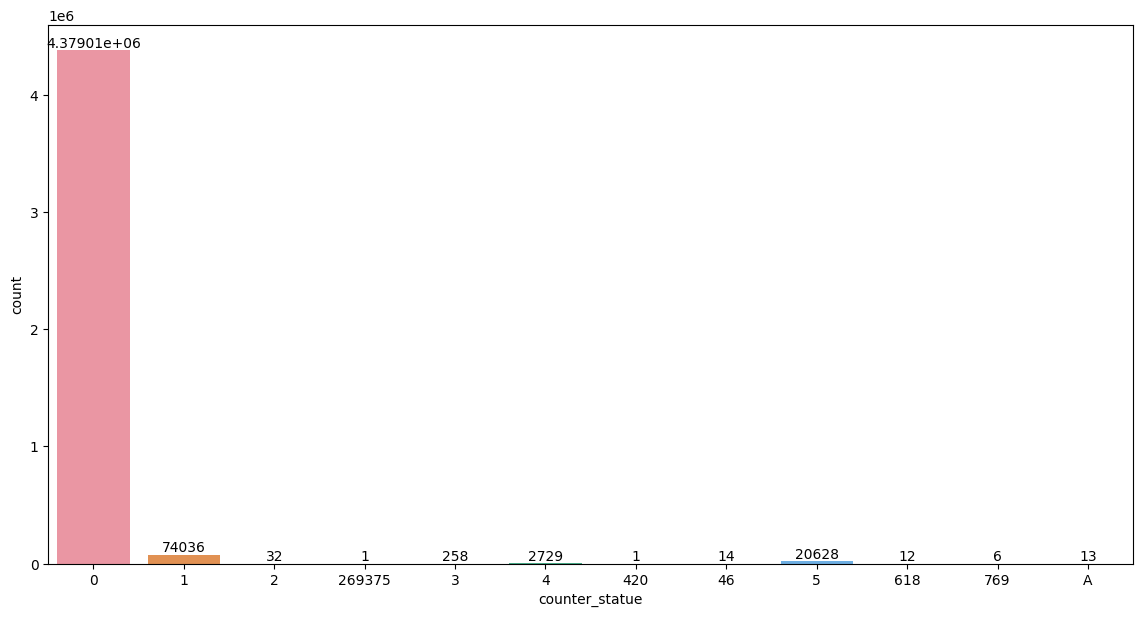

In [25]:
# Create plot
fig, ax = plt.subplots(figsize=(14, 7))  # ✅ correct argument name
ax = sns.countplot(x=invoice_train['counter_statue'], ax=ax)

# Add labels to each bar
for container in ax.containers:
    ax.bar_label(container)

# Display plot
plt.show();

These columns should only contain values between 0 and 5 based on the information provided by the source. 
Therefore, values greater than 5 will be dropped due to the low number of entries affected (47 entries, 0.00001% of the total entries)

In [26]:
# list of values to drop
values_to_drop = ['269375', '420', '46', '618', '769', 'A']
# Drop values
invoice_train = invoice_train[~invoice_train['counter_statue'].isin(values_to_drop)]

Now the counter_statue column contains only 6 values from 0 to 5.

In [27]:
# Get unique values on the invoice train data
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")


client_id - 135491
invoice_date - 8275
tarif_type - 17
counter_number - 201892
counter_statue - 6
counter_code - 40
reading_remarque - 4
counter_coefficient - 13
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1351
counter_type - 2


### Preparing the invoice_train file for a proper merge with the client_train file

First, we have got the average comsuption per level x.

In [28]:
# Calculate mean values of consumption levels per client_id
def aggregate_by_client_id(invoice_data):
    aggs = {}
    aggs['consommation_level_1'] = ['mean']
    aggs['consommation_level_2'] = ['mean']
    aggs['consommation_level_3'] = ['mean']
    aggs['consommation_level_4'] = ['mean']

    agg_trans = invoice_data.groupby(['client_id']).agg(aggs)
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (invoice_data.groupby('client_id')
            .size()
            .reset_index(name='{}transactions_count'.format('1')))
    return pd.merge(df, agg_trans, on='client_id', how='left')

In [29]:
# Group invoice data by client_id
agg_train = aggregate_by_client_id(invoice_train)

In [30]:
# Display overview of the new aggregated data frame
print(agg_train.shape)
agg_train.head()

(135491, 6)


,client_id,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,train_Client_0,35,352.400000,10.571429,0.000000,0.000000
1,train_Client_1,37,557.540541,0.000000,0.000000,0.000000
2,train_Client_10,18,798.611111,37.888889,0.000000,0.000000
3,train_Client_100,20,1.200000,0.000000,0.000000,0.000000
4,train_Client_1000,14,663.714286,104.857143,117.357143,36.714286


Now, some relevant columns are added to the new data frame 'agg_train'

In [31]:
# Define the columns that will be added
extra_col = ['client_id', 'tarif_type', 'counter_statue', 'counter_type']
invoice_subset = invoice_train[extra_col]

# Drop duplicates
invoice_unique = invoice_subset.drop_duplicates(subset='client_id')

# Merge ['tarif_type', 'counter_statue', 'counter_type'] to the main dataset
agg_train_extra_cols = pd.merge(agg_train, invoice_unique, on='client_id', how='left')

# Display extended data frame
agg_train_extra_cols.head(5)

,client_id,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,tarif_type,counter_statue,counter_type
0,train_Client_0,35,352.400000,10.571429,0.000000,0.000000,11,0,ELEC
1,train_Client_1,37,557.540541,0.000000,0.000000,0.000000,11,0,ELEC
2,train_Client_10,18,798.611111,37.888889,0.000000,0.000000,11,0,ELEC
3,train_Client_100,20,1.200000,0.000000,0.000000,0.000000,11,0,ELEC
4,train_Client_1000,14,663.714286,104.857143,117.357143,36.714286,11,0,ELEC


In [32]:
# Display the new shape
agg_train_extra_cols.shape

(135491, 9)

Now we proceed with the merging of the newly created data frame (agg_train_extra_cols) with the client_train dataset

In [33]:
# Merge aggregate data with client dataset
train = pd.merge(client_train,agg_train_extra_cols, on='client_id', how='left')

In [34]:
train.head(5)

,disrict,client_id,client_catg,region,creation_date,target,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,tarif_type,counter_statue,counter_type
0,60,train_Client_0,11,101,1994-12-31,0,35.0,352.400000,10.571429,0.000000,0.000000,11,0,ELEC
1,69,train_Client_1,11,107,2002-05-29,0,37.0,557.540541,0.000000,0.000000,0.000000,11,0,ELEC
2,62,train_Client_10,11,301,1986-03-13,0,18.0,798.611111,37.888889,0.000000,0.000000,11,0,ELEC
3,69,train_Client_100,11,105,1996-07-11,0,20.0,1.200000,0.000000,0.000000,0.000000,11,0,ELEC
4,62,train_Client_1000,11,303,2014-10-14,0,14.0,663.714286,104.857143,117.357143,36.714286,11,0,ELEC


### Quick EDA for the final data frame

* It contains 2 null values that have been dropped
* There are no duplicates
* Header disrict replaced by district
* Data types are correct
* Client_id has not been modified as it will no be part of the features

In [35]:
# Check data frame shape
train.shape

(135493, 14)

In [36]:
# Check number of null values per column
train.isnull().sum()

disrict                      0
client_id                    0
client_catg                  0
region                       0
creation_date                0
target                       0
1transactions_count          2
consommation_level_1_mean    2
consommation_level_2_mean    2
consommation_level_3_mean    2
consommation_level_4_mean    2
tarif_type                   2
counter_statue               2
counter_type                 2
dtype: int64

In [37]:
# Drop null values
train = train.dropna()

In [38]:
# Count number of duplicates
print(f'The dataset contains {train.duplicated().sum()} duplicates')

The dataset contains 0 duplicates


In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135491 entries, 0 to 135492
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   disrict                    135491 non-null  category      
 1   client_id                  135491 non-null  object        
 2   client_catg                135491 non-null  category      
 3   region                     135491 non-null  category      
 4   creation_date              135491 non-null  datetime64[ns]
 5   target                     135491 non-null  int32         
 6   1transactions_count        135491 non-null  float64       
 7   consommation_level_1_mean  135491 non-null  float64       
 8   consommation_level_2_mean  135491 non-null  float64       
 9   consommation_level_3_mean  135491 non-null  float64       
 10  consommation_level_4_mean  135491 non-null  float64       
 11  tarif_type                 135491 non-null  category     

A couple of headers have been renamed to gain clarity.
Note: the data type and values of client_id haven't been adjusted as the column will not be kept as a feature.

In [40]:
# Rename headers
train.rename(columns={'1transactions_count': 'transactions_count',
                      'disrict' : 'district'}, 
                      inplace=True)

In [41]:
# Check the renaming
train.head(2)

,district,client_id,client_catg,region,creation_date,target,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,tarif_type,counter_statue,counter_type
0,60,train_Client_0,11,101,1994-12-31,0,35.0,352.400000,10.571429,0.0,0.0,11,0,ELEC
1,69,train_Client_1,11,107,2002-05-29,0,37.0,557.540541,0.000000,0.0,0.0,11,0,ELEC


Let's check the correlations of the new data frame.

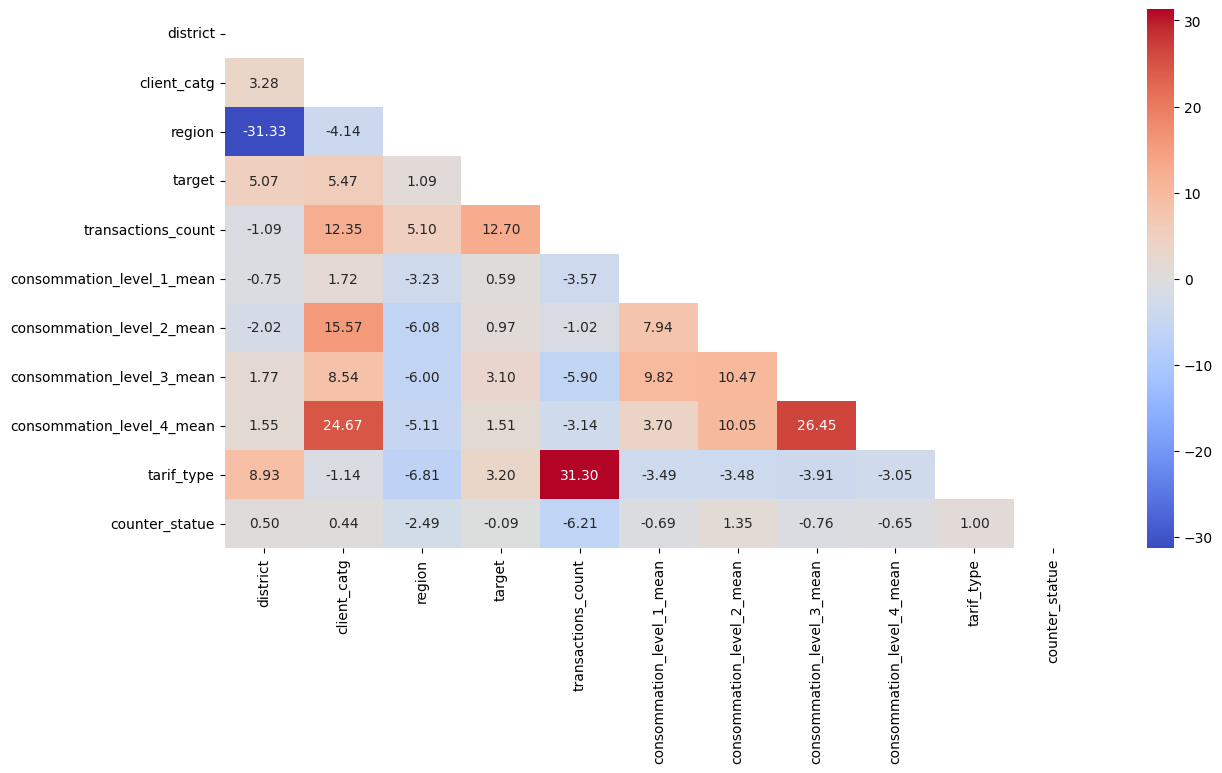

In [42]:
# Check correlation among variables
numeric_col = train.drop(columns = ['client_id', 'creation_date','counter_type'])
plt.subplots(figsize=(14, 7))
mask = np.triu(np.ones_like(numeric_col.corr(), dtype=bool))
sns.heatmap(numeric_col.corr().mul(100), mask=mask, annot=True, fmt=".2f", cmap="coolwarm");

### Baseline model

We identified three unique categories in the client_catg column: 11, 12, and 51.
For our baseline model, we assume that fraud occurs only within category '51'.

Based on this assumption, we created a new column called fraud_only_catg_51, which serves as our predicted label (y_pred).
This allows us to compare our predictions against the true labels (y_true) stored in the target column of the training dataset.

In [43]:
# Create an extra target column, where all clients from the category 51 commit fraud
train['fraud_only_catg_51'] = train['client_catg'].apply(lambda x: 1 if x == 51 else 0)

In [44]:
# Check if the assignment in the new column has been done properly
train.groupby(['client_catg','fraud_only_catg_51'])['fraud_only_catg_51'].count()

client_catg  fraud_only_catg_51
11           0                     131492
             1                          0
12           0                       2321
             1                          0
51           0                          0
             1                       1678
Name: fraud_only_catg_51, dtype: int64

Let's check the accuracy, recall, and presicion scores

In [45]:
#
accuracy_51_is_fraudelent = accuracy_score(train['target'],train['fraud_only_catg_51'])
recall_51_is_fraudelent = recall_score(train['target'],train['fraud_only_catg_51'])
presicion_51_is_fraudelent = precision_score(train['target'],train['fraud_only_catg_51'])

print(f'Accuracy score: {round(accuracy_51_is_fraudelent,3)}')
print(f'Recall score: {round(recall_51_is_fraudelent,3)}')
print(f'Precision score: {round(presicion_51_is_fraudelent,3)}')

Accuracy score: 0.936
Recall score: 0.037
Precision score: 0.169


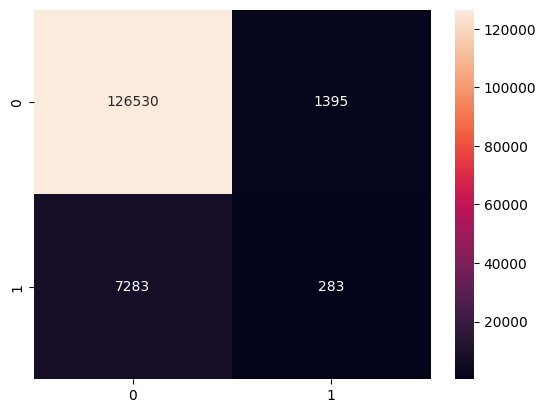

In [46]:
sns.heatmap(confusion_matrix(train['target'],train['fraud_only_catg_51']), annot = True, fmt = 'd');

This baseline model achieves a high overall accuracy of 0.936, but it performs poorly in identifying actual fraud cases.
The large number of false negatives is particularly concerning, as each undetected fraud represents a direct loss for the company.
With a recall score of only 0.037, the model fails to capture the vast majority of fraudulent transactions.
Therefore, our next goal is to develop a model that can more effectively detect fraud and minimize false negatives, even if that means sacrificing some overall accuracy.


Now that we have our baseline model defined, we can get rid off of the column 'fraud_only_catg_51'.

In [47]:
# Drop column 'fraud_only_catg_51'
train = train.drop(columns='fraud_only_catg_51')

### Target distribution

The dataset is highly imbalanced, with only a small proportion of fraud cases.
If we train our model on this data as is, it will struggle to correctly identify fraudulent transactions.
To address this issue, we’ll apply oversampling to achieve a more balanced class distribution.
Before doing so, however, we’ll first split the data into training and testing sets to ensure a fair evaluation of model performance.

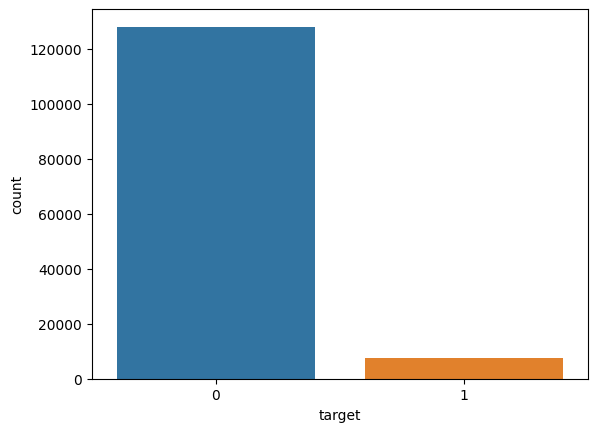

In [48]:
sns.countplot(x=train['target']);

### Running the data split

In [49]:
# Define features (X) and target (y)
X = train.drop(columns=['target','client_id','creation_date'])
y = train['target']

In [50]:
# Display the features and the target shape
print(f'X has a shape of {X.shape} and y {y.shape}')

X has a shape of (135491, 11) and y (135491,)


In [51]:
# Split the data in training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= SEED, stratify=y)

In [52]:
# Display the splits shapes
print(f'Train data: X_train has a shape of {X_train.shape} and y_shape {y_train.shape}')
print(f'Test data: X_test has a shape of {X_test.shape} and y_shape {y_test.shape}')

Train data: X_train has a shape of (94843, 11) and y_shape (94843,)
Test data: X_test has a shape of (40648, 11) and y_shape (40648,)


### Dealing with outliers

In [53]:
def outlier_detector(frame, drop=False):
    numeric_cols = frame.select_dtypes(include='number').columns  # only numeric columns
    outlier_indices = set()  # to store indices of all detected outliers

    for col in numeric_cols:
        Q1 = frame[col].quantile(0.25)
        Q3 = frame[col].quantile(0.75)
        IQR = Q3 - Q1

        # Detect outliers for this column
        outliers = frame[(frame[col] < Q1 - 1.5 * IQR) | (frame[col] > Q3 + 1.5 * IQR)]
        
        if not outliers.empty:
            print(f"Column '{col}': {len(outliers)} outlier(s) detected.")
            outlier_indices.update(outliers.index)

    if not outlier_indices:
        print("No outliers detected in any numeric columns.")

    if drop:
        print(f"\nDropping {len(outlier_indices)} outlier rows from dataset...")
        return frame.drop(index=list(outlier_indices))
    else:
        print(f"\nReturning {len(outlier_indices)} outlier rows (not dropped).")
        return frame.loc[list(outlier_indices)]


In [54]:
outlier_detector(X_train)

Column 'transactions_count': 697 outlier(s) detected.
Column 'consommation_level_1_mean': 3811 outlier(s) detected.
Column 'consommation_level_2_mean': 12923 outlier(s) detected.
Column 'consommation_level_3_mean': 20139 outlier(s) detected.
Column 'consommation_level_4_mean': 12942 outlier(s) detected.

Returning 26465 outlier rows (not dropped).


,district,client_catg,region,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,tarif_type,counter_statue,counter_type
131073,69,11,107,2.0,250.000000,100.000000,141.500000,0.000000,40,0,GAZ
9,60,11,101,5.0,850.800000,1629.200000,320.000000,4882.000000,11,0,ELEC
12,69,11,107,37.0,881.972973,158.567568,57.594595,0.000000,11,0,ELEC
131087,69,11,104,69.0,847.260870,236.391304,79.507246,52.942029,40,0,GAZ
131088,60,11,101,13.0,830.769231,414.769231,709.923077,1221.307692,11,0,ELEC
...,...,...,...,...,...,...,...,...,...,...,...
131064,62,11,310,67.0,338.985075,59.537313,61.223881,4.313433,40,0,GAZ
131065,63,11,311,3.0,1230.333333,0.000000,0.000000,0.000000,11,0,ELEC
131066,63,11,306,3.0,233.333333,238.333333,0.000000,0.000000,10,0,ELEC
131068,62,11,303,76.0,676.986842,115.644737,44.276316,1.000000,40,0,GAZ


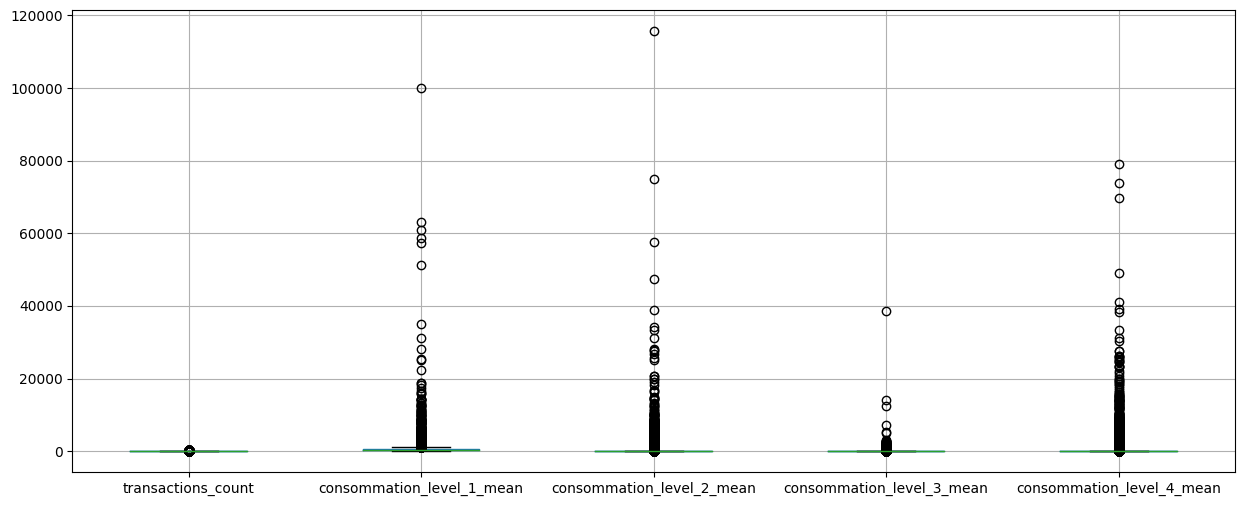

In [55]:
X_train[['transactions_count','consommation_level_1_mean','consommation_level_2_mean', 'consommation_level_3_mean', 'consommation_level_4_mean']].boxplot(figsize=(15,6))
plt.show()


The number of outliers is too high to drop them. Therefore, we'll apply a log transformation

In [56]:
cols = ['transactions_count', 'consommation_level_1_mean', 'consommation_level_2_mean',
        'consommation_level_3_mean', 'consommation_level_4_mean']
X_train.loc[:, cols] = np.log1p(X_train[cols])
X_test.loc[:, cols] = np.log1p(X_test[cols])

In [57]:
outlier_detector(X_train)

Column 'consommation_level_1_mean': 7939 outlier(s) detected.
Column 'consommation_level_2_mean': 6 outlier(s) detected.
Column 'consommation_level_3_mean': 10236 outlier(s) detected.
Column 'consommation_level_4_mean': 12942 outlier(s) detected.

Returning 22410 outlier rows (not dropped).


,district,client_catg,region,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,tarif_type,counter_statue,counter_type
131073,69,11,107,1.098612,5.525453,4.615121,4.959342,0.000000,40,0,GAZ
3,69,11,105,3.044522,0.788457,0.000000,0.000000,0.000000,11,0,ELEC
9,60,11,101,1.791759,6.747352,7.396458,5.771441,8.493515,11,0,ELEC
12,69,11,107,3.637586,6.783295,5.072467,4.070642,0.000000,11,0,ELEC
14,69,11,104,2.302585,0.000000,0.000000,0.000000,0.000000,11,0,ELEC
...,...,...,...,...,...,...,...,...,...,...,...
131055,60,11,101,3.737670,5.386284,3.714761,3.021020,2.577997,10,0,ELEC
131060,69,11,104,1.791759,6.768723,5.484797,6.175867,8.754949,11,0,ELEC
131064,62,11,310,4.219508,5.828902,4.103260,4.130739,1.670238,40,0,GAZ
131068,62,11,303,4.343805,6.519128,4.759133,3.812784,0.693147,40,0,GAZ


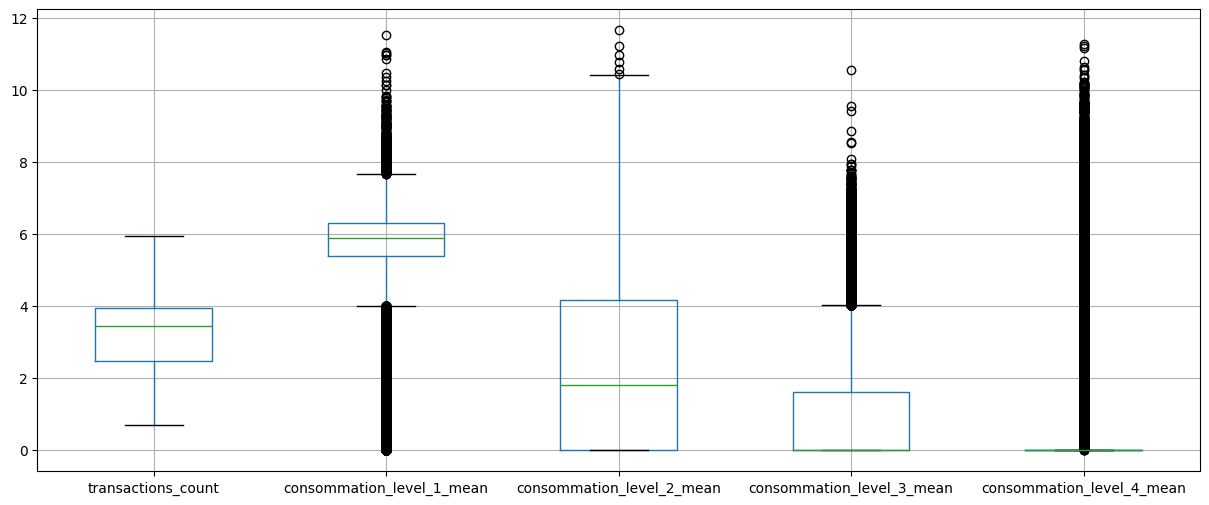

In [58]:
X_train[['transactions_count','consommation_level_1_mean','consommation_level_2_mean', 'consommation_level_3_mean', 'consommation_level_4_mean']].boxplot(figsize=(15,6))
plt.show()

### Tranforming categorical features with one-hot-encode

In [59]:
# Instantiating a OneHotEncoder object
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=True)

In [60]:
# Define categorical columns
categorical_cols = ['counter_type', 'district', 'client_catg', 'region', 'tarif_type', 'counter_statue']

# Fit encoder to column counter_type
encoder.fit(X_train[categorical_cols])

OneHotEncoder(drop='first', handle_unknown='ignore')

In [61]:
encoder.categories_

[array(['ELEC', 'GAZ'], dtype=object),
 array([60, 62, 63, 69], dtype=int64),
 array([11, 12, 51], dtype=int64),
 array([101, 103, 104, 105, 106, 107, 206, 301, 302, 303, 304, 305, 306,
        307, 308, 309, 310, 311, 312, 313, 371, 372, 379, 399], dtype=int64),
 array([ 9, 10, 11, 12, 13, 14, 15, 21, 24, 29, 30, 40, 45], dtype=int64),
 array(['0', '1', '2', '3', '4', '5'], dtype=object)]

In [62]:
encoder.get_feature_names_out()

array(['counter_type_GAZ', 'district_62', 'district_63', 'district_69',
       'client_catg_12', 'client_catg_51', 'region_103', 'region_104',
       'region_105', 'region_106', 'region_107', 'region_206',
       'region_301', 'region_302', 'region_303', 'region_304',
       'region_305', 'region_306', 'region_307', 'region_308',
       'region_309', 'region_310', 'region_311', 'region_312',
       'region_313', 'region_371', 'region_372', 'region_379',
       'region_399', 'tarif_type_10', 'tarif_type_11', 'tarif_type_12',
       'tarif_type_13', 'tarif_type_14', 'tarif_type_15', 'tarif_type_21',
       'tarif_type_24', 'tarif_type_29', 'tarif_type_30', 'tarif_type_40',
       'tarif_type_45', 'counter_statue_1', 'counter_statue_2',
       'counter_statue_3', 'counter_statue_4', 'counter_statue_5'],
      dtype=object)

In [63]:
# Transform both train and test using the same encoder
X_train_encoded = encoder.transform(X_train[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])

c:\Users\farle\spiced\depos\fraud-detection\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [64]:
X_train_encoded_dense = X_train_encoded.todense()
X_test_encoded_dense = X_test_encoded.todense()

In [65]:
X_train_encoded_df = pd.DataFrame(data=X_train_encoded_dense, columns= encoder.get_feature_names_out(categorical_cols), index=X_train.index)
X_test_encoded_df = pd.DataFrame(data=X_test_encoded_dense, columns= encoder.get_feature_names_out(categorical_cols), index=X_test.index)

In [66]:
# Drop the original column and concatenate the new encoded columns
X_train = pd.concat([X_train.drop(columns= categorical_cols), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(columns= categorical_cols), X_test_encoded_df], axis=1)

In [67]:
# Display data frame
X_train.head(5)

,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,counter_type_GAZ,district_62,district_63,district_69,client_catg_12,...,tarif_type_24,tarif_type_29,tarif_type_30,tarif_type_40,tarif_type_45,counter_statue_1,counter_statue_2,counter_statue_3,counter_statue_4,counter_statue_5
28199,2.079442,5.528295,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18397,4.043051,5.661409,5.614626,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
47941,0.693147,6.579251,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36406,2.772589,6.509166,4.641824,3.442553,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33319,3.931826,6.012639,2.924236,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Scaling

In [68]:
# Define the scaler
st_scaler = StandardScaler()
# List of columns that will be transformed
col_list = ['transactions_count', 'consommation_level_1_mean', 'consommation_level_2_mean', 'consommation_level_3_mean', 'consommation_level_4_mean']

In [69]:
# Scale numerical features
X_train_scaled = st_scaler.fit_transform(X_train[col_list])
X_test_scaled = st_scaler.transform(X_test[col_list])

In [70]:
# Convert back to DataFrames with same column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=col_list, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=col_list, index=X_test.index)

In [71]:
# combine scaled columns with the rest of the dataset
X_train_preprocessed = pd.concat([X_train.drop(columns=col_list),X_train_scaled_df], axis=1)
X_test_preprocessed = pd.concat([X_test.drop(columns=col_list), X_test_scaled_df], axis=1)

In [72]:
# Check the scaling
X_train_preprocessed.head(5)

,counter_type_GAZ,district_62,district_63,district_69,client_catg_12,client_catg_51,region_103,region_104,region_105,region_106,...,counter_statue_1,counter_statue_2,counter_statue_3,counter_statue_4,counter_statue_5,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
28199,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.010300,-0.042906,-0.957644,-0.562626,-0.35013
18397,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.887561,0.054933,1.489075,-0.562626,-0.35013
47941,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-2.350176,0.729543,-0.957644,-0.562626,-0.35013
36406,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.340362,0.678031,1.065151,1.370462,-0.35013
33319,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.780060,0.313085,0.316668,-0.562626,-0.35013


### Oversampling with SMOTE

In [73]:
# Oversample the target to balance fraud and no fraud
smote = SMOTE(random_state=12)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)


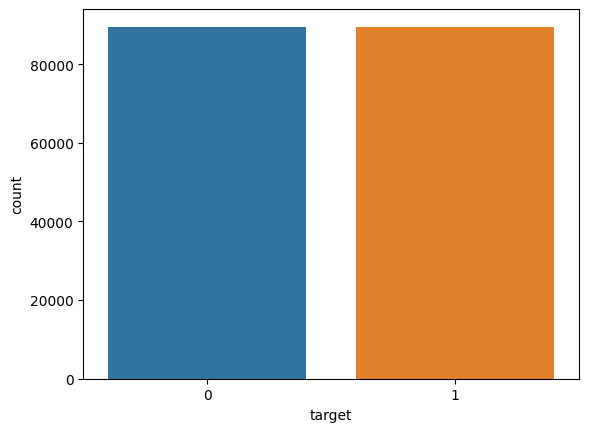

In [74]:
# Display target distribution
sns.countplot(x=y_train_resampled);

### Now it’s time to train our models:

* Logistic Regression
* Random Forest
* K-Nearest Neighbors (KNN)

Before fitting them to the data, we’ll perform hyperparameter tuning using Grid Search.
This process will help us identify the best combination of hyperparameters for each model, ensuring optimal performance.


In [75]:
# --- Define models ---
models = {
    'Logistic Regression': LogisticRegression(random_state=SEED, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=SEED),
    'KNN': KNeighborsClassifier()
}

# --- Define parameter grids ---
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear']
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10, 15]
    },
    'KNN': {
        'n_neighbors': [5, 10, 15, 20, 25, 30],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan','minkowski']
    }
}

# --- Run Grid Search for each model ---
best_models = {}

for name, model in models.items():
    print(f"\nRunning Grid Search for {name}...")
    
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring='recall',   # Focus on detecting frauds
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train_resampled, y_train_resampled)
    best_models[name] = grid.best_estimator_
    
    print(f"Best params for {name}: {grid.best_params_}")
    print(f"Best CV recall: {grid.best_score_:.4f}")


Running Grid Search for Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params for Logistic Regression: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV recall: 0.7289

Running Grid Search for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Best CV recall: 0.9316

Running Grid Search for KNN...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params for KNN: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
Best CV recall: 0.9532


Now we have the best hyperparameter per model, let's see how the work when passing the unseen data

### Logistic Regresion

#### Cross validation

In [141]:
# Defines logistic regresion
lr = LogisticRegression(C= 0.01, penalty= 'l2', solver= 'liblinear', max_iter= 1000, class_weight= 'balanced')

# Define cross validation
cros_val_lr = cross_val_score(lr, X_train_resampled, y_train_resampled, cv = 5, scoring = 'recall', n_jobs = -1)

# Run cross validation within the training data
print(f'Average cross validation score: {round(cros_val_lr.mean(),3)}')

Average cross validation score: 0.729


#### Threshold tuning

In [153]:
y_proba = lr.predict_proba(X_test_preprocessed)[:, 1]

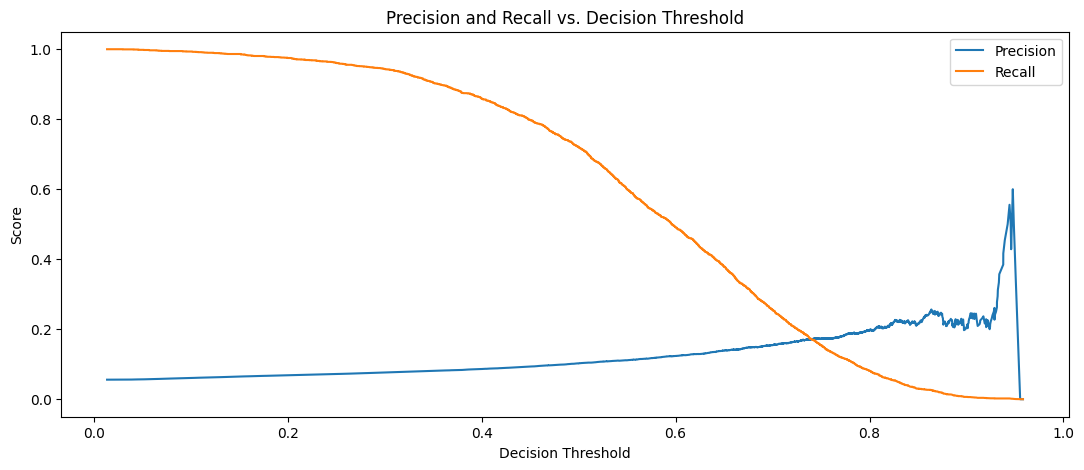

In [ ]:
# Create a plot
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
fig, ax = plt.subplots(figsize = (13, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision and Recall vs. Decision Threshold')
plt.show()


In [ ]:
# Define the threshold to achieve a recall of 0.8
desired_recall = 0.8
threshold_recall = thresholds[np.argmax(recall[:-1] < desired_recall)]
print("Threshold with recall ≥ 0.8:", round(threshold_recall, 3))


Threshold with recall ≥ 0.8: 0.448


Our primary objective is to detect as many fraud cases as possible. As shown in the precision–recall curve, lowering the decision threshold to around 0.448 would allow us to achieve a recall score of approximately 0.8, with only a limited decrease in precision due to its relatively flat trend in that region.

However, since the business cost associated with false positives is not clearly defined, we will keep the default decision threshold at 0.5 for now. This maintains a balanced trade-off between precision and recall until more information is available about the impact of false alarms.

#### Model fitting

Applying the model over the test data

In [142]:
# Fit model with training data
lr.fit(X_train_resampled, y_train_resampled)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000,
                   solver='liblinear')

In [143]:
# Define y_pred
y_pred_lr = lr.predict(X_test_preprocessed)

Accuracy score: 0.633
Recall score: 0.72
Precision score: 0.103


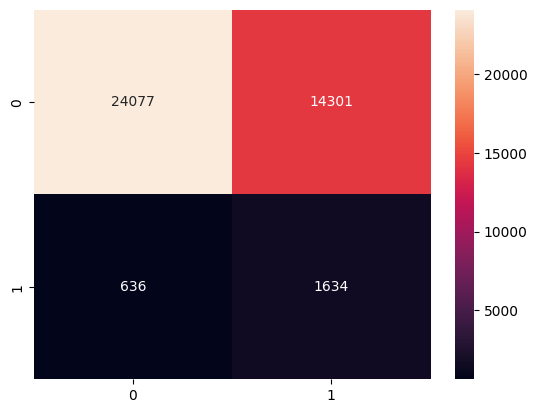

In [144]:
# Define evaluation metrics

print(f'Accuracy score: {round(accuracy_score(y_test, y_pred_lr),3)}')
print(f'Recall score: {round(recall_score(y_test, y_pred_lr),3)}')
print(f'Precision score: {round(precision_score(y_test, y_pred_lr),3)}')

# Define confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot = True, fmt= 'd');

Applying the model over the train data before resampling with SMOTE

In [145]:
# Define y_pred
y_pred_lr_train = lr.predict(X_train_preprocessed)

Accuracy score: 0.627
Recall score: 0.716
Precision score: 0.101


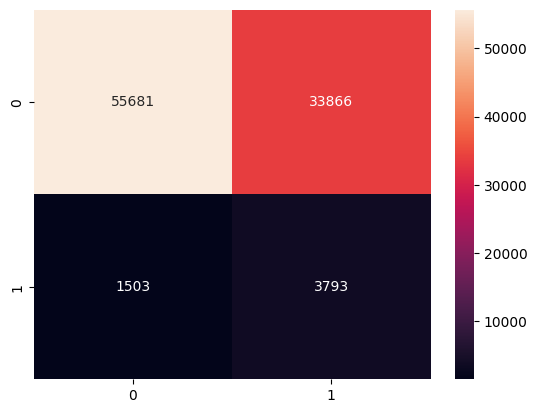

In [147]:
# Define evaluation metrics

print(f'Accuracy score: {round(accuracy_score(y_train, y_pred_lr_train),3)}')
print(f'Recall score: {round(recall_score(y_train, y_pred_lr_train),3)}')
print(f'Precision score: {round(precision_score(y_train, y_pred_lr_train),3)}')

# Define confusion matrix
sns.heatmap(confusion_matrix(y_train, y_pred_lr_train), annot = True, fmt= 'd');

### Random Forest

#### Cross validation

In [129]:
# Define Random Forest
rf = RandomForestClassifier(max_depth = None, min_samples_split = 2, n_estimators = 300, class_weight= 'balanced', random_state= SEED)

# Define cross validation
cros_val_rf = cross_val_score(rf, X_train_resampled, y_train_resampled, cv = 5, scoring = 'recall', n_jobs = -1)

# Average cross validation score
print(f'Average cross validation score: {round(cros_val_rf.mean(),3)}')

Average cross validation score: 0.932


#### Model fitting

Applying the model over the test data

In [131]:
rf.fit(X_train_resampled,y_train_resampled)

RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=12)

In [137]:
# Defines y_pred
y_pred_rf = rf.predict(X_test_preprocessed)

Accuracy score: 0.86
Recall score: 0.248
Precision score: 0.124


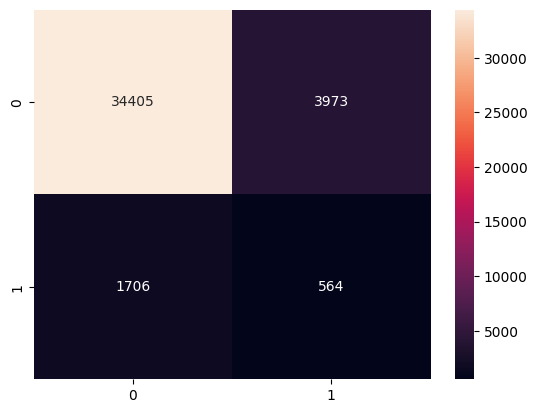

In [138]:
# Define evaluation metrics

print(f'Accuracy score: {round(accuracy_score(y_test, y_pred_rf),3)}')
print(f'Recall score: {round(recall_score(y_test, y_pred_rf),3)}')
print(f'Precision score: {round(precision_score(y_test, y_pred_rf),3)}')

# Define confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot = True, fmt= 'd');

Applying the model over the train data before resampling with SMOTE

In [162]:
# Define y_pred
y_pred_rf_train = rf.predict(X_train_preprocessed)

Accuracy score: 1.0
Recall score: 0.996
Precision score: 1.0


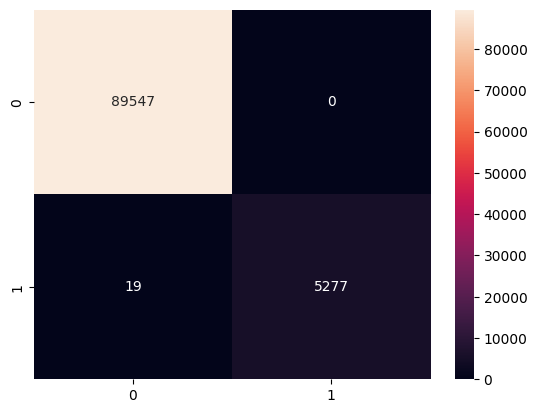

In [163]:
# Define evaluation metrics

print(f'Accuracy score: {round(accuracy_score(y_train, y_pred_rf_train),3)}')
print(f'Recall score: {round(recall_score(y_train, y_pred_rf_train),3)}')
print(f'Precision score: {round(precision_score(y_train, y_pred_rf_train),3)}')

# Define confusion matrix
sns.heatmap(confusion_matrix(y_train, y_pred_rf_train), annot = True, fmt= 'd');

Tune decision threshold to improve recall

🔍 Threshold tuning results:
    threshold    recall  precision        f1
0       0.10  0.772687   0.086031  0.154824
1       0.15  0.682379   0.091311  0.161069
2       0.20  0.613216   0.097973  0.168953
3       0.25  0.526872   0.100741  0.169142
4       0.30  0.462996   0.106560  0.173247
5       0.35  0.406167   0.112384  0.176055
6       0.40  0.350220   0.116569  0.174917
7       0.45  0.296916   0.119695  0.170611
8       0.50  0.248458   0.124311  0.165712
9       0.55  0.203965   0.127654  0.157029
✅ Best threshold based on F1: 0.3500000000000001

📊 Final Model Performance:
Accuracy:  0.788
Recall:    0.406
Precision: 0.112
F1 Score:  0.176

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.81      0.88     38378
           1       0.11      0.41      0.18      2270

    accuracy                           0.79     40648
   macro avg       0.54      0.61      0.53     40648
weighted avg       0.91      0.79      0.84  

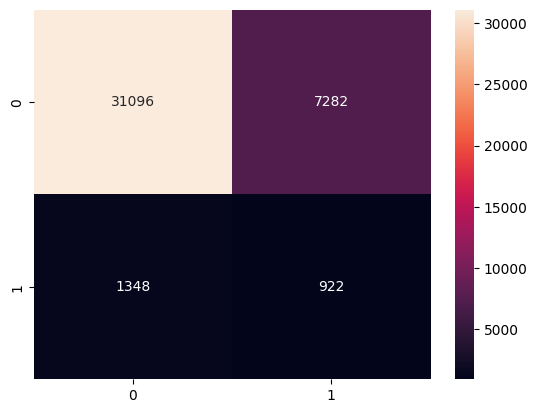

In [140]:
y_proba_rf = rf.predict_proba(X_test_preprocessed)[:, 1]
 
# Try multiple thresholds and pick the one that gives best recall-F1 tradeoff
thresholds = np.arange(0.1, 0.6, 0.05)
results = []

for t in thresholds:
    y_pred_t = (y_proba_rf > t).astype(int)
    results.append({
        'threshold': t,
        'recall': recall_score(y_test, y_pred_t),
        'precision': precision_score(y_test, y_pred_t),
        'f1': f1_score(y_test, y_pred_t)
    })

results_df = pd.DataFrame(results)
print("🔍 Threshold tuning results:\n", results_df)

# Pick the best threshold (e.g., one with highest recall or best F1)
best_thresh = results_df.loc[results_df['f1'].idxmax(), 'threshold']
print(f"✅ Best threshold based on F1: {best_thresh}")

# Predict again with the chosen threshold
y_pred_rf_best = (y_proba_rf > best_thresh).astype(int)

# Final evaluation
print("\n📊 Final Model Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rf_best):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred_rf_best):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_rf_best):.3f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_rf_best):.3f}")

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf_best))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf_best), annot=True, fmt='d');


### KNN

Cross validation

In [99]:
neighbors = [5, 10, 15, 20, 25, 30, 35, 40]

for n in neighbors:
    knn = KNeighborsClassifier(metric= 'euclidean', n_neighbors= n, weights= 'distance')
    scores = cross_val_score(knn, X = X_train_resampled, y = y_train_resampled, cv = 5,scoring = 'recall', n_jobs = -1)
    print(f'Neighbors = {n}, Average score = {scores.mean()}')

Neighbors = 5, Average score = 0.9498922953093185
Neighbors = 10, Average score = 0.9532424763333733
Neighbors = 15, Average score = 0.9526952785281282
Neighbors = 20, Average score = 0.9514445344521854
Neighbors = 25, Average score = 0.9498476175493458
Neighbors = 30, Average score = 0.9476364868248401
Neighbors = 35, Average score = 0.9451126791226532
Neighbors = 40, Average score = 0.9431695632043118


In [100]:
neighbors = [5, 10, 15, 20, 25, 30, 35, 40]

for n in neighbors:
    knn = KNeighborsClassifier(metric= 'euclidean', n_neighbors= n, weights= 'distance')
    scores = cross_val_score(knn, X = X_train_preprocessed, y = y_train, cv = 5,scoring = 'recall', n_jobs = -1)
    print(f'Neighbors = {n}, Average score = {scores.mean()}')

Neighbors = 5, Average score = 0.03587524720722647
Neighbors = 10, Average score = 0.016805459048229908
Neighbors = 15, Average score = 0.007552692999804015
Neighbors = 20, Average score = 0.004153972241523687
Neighbors = 25, Average score = 0.0024546118623835233
Neighbors = 30, Average score = 0.0015105029664867176
Neighbors = 35, Average score = 0.0011327881411798244
Neighbors = 40, Average score = 0.0009441088958968055


The hyperparameters recommended by the grid search make the model have a very high variance due to overfitting as KNN memorizes the training data but generalizes poorly.
This happens because KNN is non-parametric and sensitive to noise, feature scaling, and data imbalance.


During cross-validation, we have trained and validated on the oversampled (SMOTE) dataset, where classes are well balanced.
On that data, KNN sees many more fraud examples and learns their patterns easily, which is good for training but it's not realistic. That’s why recall is so high (overfitting)


When we switch to the real test set, the data is still highly imbalanced. Now, KNN struggles to find enough positive neighbors and misses many frauds as many of those fraud points are far from any synthetic examples generated by SMOTE. (recall drops to 0.435).

KNN is a “lazy learner” — it doesn’t learn decision boundaries, it just memorizes points and looks for the closest neighbors.

* Synthetic points created by SMOTE don’t exactly match the real fraud distribution.
* The model’s “memory” is biased toward these synthetic regions.
* On the real test set, fraud points may not fall near those synthetic neighbors → misclassified as non-fraud.

Scores using training data (oversampled data SMOTE)
Accuracy score: 1.0
Accuracy score: 1.0
Accuracy score: 1.0

Scores using test data
Accuracy score: 0.75
Recall score: 0.435
Precision score: 0.1


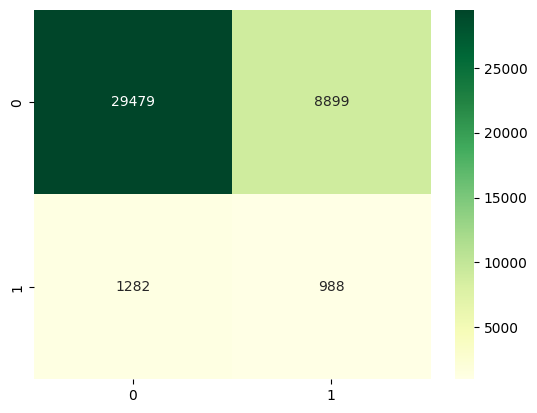

In [102]:
knn = KNeighborsClassifier(metric= 'euclidean', n_neighbors= 10, weights= 'distance')
knn.fit(X_train_resampled, y_train_resampled)
y_pred_knn = knn.predict(X_test_preprocessed)

print('Scores using training data (oversampled data SMOTE)')
print(f'Accuracy score: {round(accuracy_score(y_train_resampled, knn.predict(X_train_resampled)),3)}')
print(f'Accuracy score: {round(recall_score(y_train_resampled, knn.predict(X_train_resampled)),3)}')
print(f'Accuracy score: {round(precision_score(y_train_resampled, knn.predict(X_train_resampled)),3)}')


print('\nScores using test data')
print(f'Accuracy score: {round(accuracy_score(y_test, y_pred_knn),3)}')
print(f'Recall score: {round(recall_score(y_test, y_pred_knn),3)}')
print(f'Precision score: {round(precision_score(y_test, y_pred_knn),3)}')


# Print confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, cmap='YlGn', fmt = 'd');

Based on the plot when setting the number of neighbors too low the model overfits (< 10). On the other hand, if the number of neighbors increases more

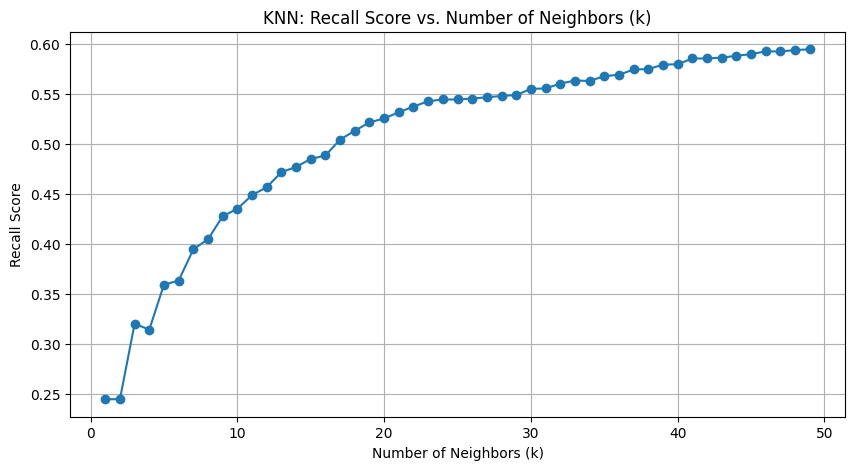

In [96]:
# Plot a graph recall score vs number of neighbors (k)

k_values = range(1, 50)
recalls = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train_resampled, y_train_resampled)
    y_pred = knn.predict(X_test_preprocessed)
    recalls.append(recall_score(y_test, y_pred))

plt.figure(figsize=(10, 5))
plt.plot(k_values, recalls, marker='o')
plt.title("KNN: Recall Score vs. Number of Neighbors (k)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Recall Score")
plt.grid(True)
plt.show()
